<a href="https://colab.research.google.com/github/abaskon/Thesis/blob/main/VAR_analysisScaledGPR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#####Import Libraries

In [ ]:
!pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
import arch
from arch import arch_model
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler



#####Read data and standardise them

In [ ]:
dbi1 = pd.read_csv("https://raw.githubusercontent.com/abaskon/Thesis/main/Data/DBI1985-2004.csv")
dbi2 = pd.read_csv("https://raw.githubusercontent.com/abaskon/Thesis/main/Data/DBI2004-today.csv")

dbi1['Price'] = dbi1['Price'].str.replace(',', '').astype(float)
dbi2['Price'] = dbi2['Price'].str.replace(',', '').astype(float)

In [ ]:
dbi1['Date'] = pd.to_datetime(dbi1['Date'], format='%m/%d/%Y')
dbi2['Date'] = pd.to_datetime(dbi2['Date'], format='%m/%d/%Y')

In [ ]:
dbi1.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2004-11-22,5442.0,"5,442.00","5,442.00","5,442.00",NaN,0.91%
1,2004-11-19,5393.0,"5,393.00","5,393.00","5,393.00",NaN,1.09%
2,2004-11-18,5335.0,"5,335.00","5,335.00","5,335.00",NaN,1.35%
3,2004-11-17,5264.0,"5,264.00","5,264.00","5,264.00",NaN,1.41%
4,2004-11-16,5191.0,"5,191.00","5,191.00","5,191.00",NaN,0.76%


In [ ]:
# concatenate the two tables based on the 'date' column
DBI = pd.concat([dbi1, dbi2]).drop_duplicates(subset='Date')

DBI = DBI.sort_values(by='Date', ascending=True)
DBI = DBI.reset_index(drop=True)

In [ ]:
DBI

,Date,Price,Open,High,Low,Vol.,Change %
0,1985-01-07,998.5,998.50,998.50,998.50,NaN,-0.15%
1,1985-01-08,996.5,996.50,996.50,996.50,NaN,-0.20%
2,1985-01-09,994.5,994.50,994.50,994.50,NaN,-0.20%
3,1985-01-10,979.5,979.50,979.50,979.50,NaN,-1.51%
4,1985-01-11,980.5,980.50,980.50,980.50,NaN,0.10%
...,...,...,...,...,...,...,...
9595,2023-04-28,1576.0,"1,576.00","1,576.00","1,576.00",NaN,-0.32%
9596,2023-05-02,1552.0,"1,552.00","1,552.00","1,552.00",NaN,-1.52%
9597,2023-05-03,1558.0,"1,558.00","1,558.00","1,558.00",NaN,0.39%
9598,2023-05-04,1545.0,"1,545.00","1,545.00","1,545.00",NaN,-0.83%


In [ ]:
GPR = pd.read_csv("https://raw.githubusercontent.com/abaskon/Thesis/main/Data/data_gpr_daily_recent.csv")
GPRE = pd.read_csv("https://raw.githubusercontent.com/abaskon/Thesis/main/Data/data_gpr_export.csv")
GPR['GPRD'] = GPR['GPRD'].str.replace(',', '').astype(float)


In [ ]:
GPR

,DAY,N10D,GPRD,GPRD_ACT,GPRD_THREAT,date,GPRD_MA30,GPRD_MA7,event,var_name,var_label
0,19850101,216,230.04,275.20,153.03,01-01-1985,230.04,230.04,NaN,DAY,DAY
1,19850102,315,115.68,146.77,87.44,02-01-1985,172.86,172.86,NaN,N10D,"Number of articles (10 recent newspapers, 1985-)"
2,19850103,374,97.43,158.94,29.46,03-01-1985,147.71,147.71,NaN,GPRD,Daily GPR (Index: 1985:2019=100)
3,19850104,421,157.37,156.88,157.03,04-01-1985,150.13,150.13,NaN,GPRD_ACT,Daily GPR Acts (Index: 1985:2019=100)
4,19850105,285,81.36,92.70,77.32,05-01-1985,136.37,136.37,NaN,GPRD_THREAT,Daily GPR Threats (Index: 1985:2019=100)
...,...,...,...,...,...,...,...,...,...,...,...
13988,20230420,470,98.67,126.47,70.33,20-04-2023,93.04,98.11,NaN,NaN,NaN
13989,20230421,453,117.00,102.06,121.61,21-04-2023,92.90,98.72,NaN,NaN,NaN
13990,20230422,522,63.46,101.22,31.66,22-04-2023,91.56,95.33,NaN,NaN,NaN
13991,20230423,355,55.99,93.02,31.04,23-04-2023,90.75,97.36,NaN,NaN,NaN


In [ ]:
GPR['date'] = pd.to_datetime(GPR['date'], format='%d-%m-%Y')
GPR = GPR.rename(columns={'date': 'Date'})

In [ ]:
GPR = GPR[['Date', 'GPRD', 'event']]

In [ ]:
GPR.head(4)

,Date,GPRD,event
0,1985-01-01,230.04,NaN
1,1985-01-02,115.68,NaN
2,1985-01-03,97.43,NaN
3,1985-01-04,157.37,NaN


In [ ]:
GPRE['month'] = pd.to_datetime(GPRE['month'], format='%d-%m-%Y')
GPRE = GPRE.rename(columns={'month': 'Date'})

In [ ]:
GPRE.head(6)

,Date,GPR,GPRT,GPRA,GPRH,GPRHT,GPRHA,SHARE_GPR,N10,SHARE_GPRH,...,GPRHC_THA,GPRHC_TUN,GPRHC_TUR,GPRHC_TWN,GPRHC_UKR,GPRHC_USA,GPRHC_VEN,GPRHC_ZAF,var_name,var_label
0,1900-01-01,NaN,NaN,NaN,87.93,64.72,110.45,NaN,NaN,3.17,...,0.08,0.00,0.04,0.00,0.0,2.72,0.05,1.15,month,Date (year/month)
1,1900-02-01,NaN,NaN,NaN,86.57,71.94,96.25,NaN,NaN,3.12,...,0.08,0.00,0.13,0.00,0.0,2.73,0.03,1.14,GPR,Recent GPR (Index: 1985:2019=100)
2,1900-03-01,NaN,NaN,NaN,72.14,57.48,84.50,NaN,NaN,2.60,...,0.12,0.00,0.18,0.00,0.0,2.15,0.03,0.86,GPRT,Recent GPR Threats (Index: 1985:2019=100)
3,1900-04-01,NaN,NaN,NaN,54.42,37.33,65.86,NaN,NaN,1.96,...,0.04,0.00,0.07,0.00,0.0,1.78,0.00,0.64,GPRA,Recent GPR Acts (Index: 1985:2019=100)
4,1900-05-01,NaN,NaN,NaN,64.41,48.20,74.37,NaN,NaN,2.32,...,0.16,0.00,0.08,0.00,0.0,1.97,0.01,0.79,GPRH,Historical GPR (Index: 1900:2019=100)
5,1900-06-01,NaN,NaN,NaN,83.61,70.01,93.98,NaN,NaN,3.02,...,0.08,0.01,0.11,0.03,0.0,2.73,0.03,0.67,GPRHT,Historical GPR Threats (Index: 1900:2019=100)


In [ ]:
GPRE[GPRE["Date"] == "1985-02-01"]

,Date,GPR,GPRT,GPRA,GPRH,GPRHT,GPRHA,SHARE_GPR,N10,SHARE_GPRH,...,GPRHC_THA,GPRHC_TUN,GPRHC_TUR,GPRHC_TWN,GPRHC_UKR,GPRHC_USA,GPRHC_VEN,GPRHC_ZAF,var_name,var_label
1021,1985-02-01,117.1,126.44,96.6,99.55,127.21,75.1,3.51,10819.0,3.59,...,0.2,0.04,0.03,0.0,0.01,3.34,0.07,0.11,NaN,NaN


In [ ]:
GPR[GPR["Date"] == "1985-02-01"]

,Date,GPRD,event
31,1985-02-01,106.61,NaN


In [ ]:
GPRE = GPRE[['Date', 'GPR','GPRC_ARG', 'GPRC_AUS', 'GPRC_BEL', 'GPRC_BRA', 'GPRC_CAN', 'GPRC_CHE', 'GPRC_CHL', 'GPRC_CHN', 'GPRC_COL', 'GPRC_DEU', 'GPRC_DNK', 'GPRC_EGY', 'GPRC_ESP', 'GPRC_FIN', 'GPRC_FRA', 'GPRC_GBR', 'GPRC_HKG', 'GPRC_HUN', 'GPRC_IDN', 'GPRC_IND', 'GPRC_ISR', 'GPRC_ITA', 'GPRC_JPN', 'GPRC_KOR', 'GPRC_MEX', 'GPRC_MYS', 'GPRC_NLD', 'GPRC_NOR', 'GPRC_PER', 'GPRC_PHL', 'GPRC_POL', 'GPRC_PRT', 'GPRC_RUS', 'GPRC_SAU', 'GPRC_SWE', 'GPRC_THA', 'GPRC_TUN', 'GPRC_TUR', 'GPRC_TWN', 'GPRC_UKR', 'GPRC_USA', 'GPRC_VEN', 'GPRC_ZAF']]

In [ ]:
GPRE = GPRE[GPRE['Date'] >= '1985-01-01']

In [ ]:
GPRE

,Date,GPR,GPRC_ARG,GPRC_AUS,GPRC_BEL,GPRC_BRA,GPRC_CAN,GPRC_CHE,GPRC_CHL,GPRC_CHN,...,GPRC_SAU,GPRC_SWE,GPRC_THA,GPRC_TUN,GPRC_TUR,GPRC_TWN,GPRC_UKR,GPRC_USA,GPRC_VEN,GPRC_ZAF
1020,1985-01-01,102.17,0.09,0.06,0.16,0.05,0.41,0.11,0.03,0.28,...,0.05,0.08,0.25,0.01,0.05,0.03,0.01,2.57,0.01,0.16
1021,1985-02-01,117.10,0.03,0.35,0.18,0.02,0.45,0.06,0.06,0.18,...,0.12,0.10,0.16,0.03,0.02,0.01,0.01,2.86,0.05,0.08
1022,1985-03-01,124.78,0.08,0.12,0.17,0.02,0.59,0.20,0.09,0.11,...,0.06,0.02,0.15,0.04,0.24,0.00,0.03,2.95,0.04,0.15
1023,1985-04-01,87.93,0.03,0.07,0.08,0.03,0.34,0.02,0.05,0.20,...,0.10,0.03,0.05,0.00,0.12,0.02,0.03,2.00,0.12,0.14
1024,1985-05-01,103.26,0.07,0.04,0.10,0.07,0.43,0.06,0.05,0.13,...,0.09,0.08,0.06,0.02,0.02,0.01,0.01,2.39,0.11,0.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1474,2022-11-01,118.74,0.03,0.12,0.28,0.13,0.28,0.05,0.01,1.15,...,0.17,0.14,0.04,0.03,0.49,0.40,2.48,2.75,0.03,0.08
1475,2022-12-01,113.86,0.03,0.20,0.19,0.06,0.22,0.06,0.01,0.89,...,0.17,0.11,0.03,0.01,0.26,0.30,2.26,2.60,0.06,0.04
1476,2023-01-01,105.63,0.03,0.13,0.21,0.12,0.29,0.17,0.02,0.70,...,0.05,0.17,0.03,0.01,0.22,0.17,1.99,2.42,0.03,0.04
1477,2023-02-01,127.34,0.01,0.16,0.34,0.06,0.42,0.05,0.04,1.58,...,0.15,0.15,0.02,0.01,0.51,0.37,2.12,3.15,0.02,0.10


#####Visualisations

In [ ]:
def plotgraph(df, x, y):
    df[y] = pd.to_numeric(df[y])
    df.plot(x=x, y=y, figsize=(20, 4))
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('USD per Metric Tonne')
    plt.show()


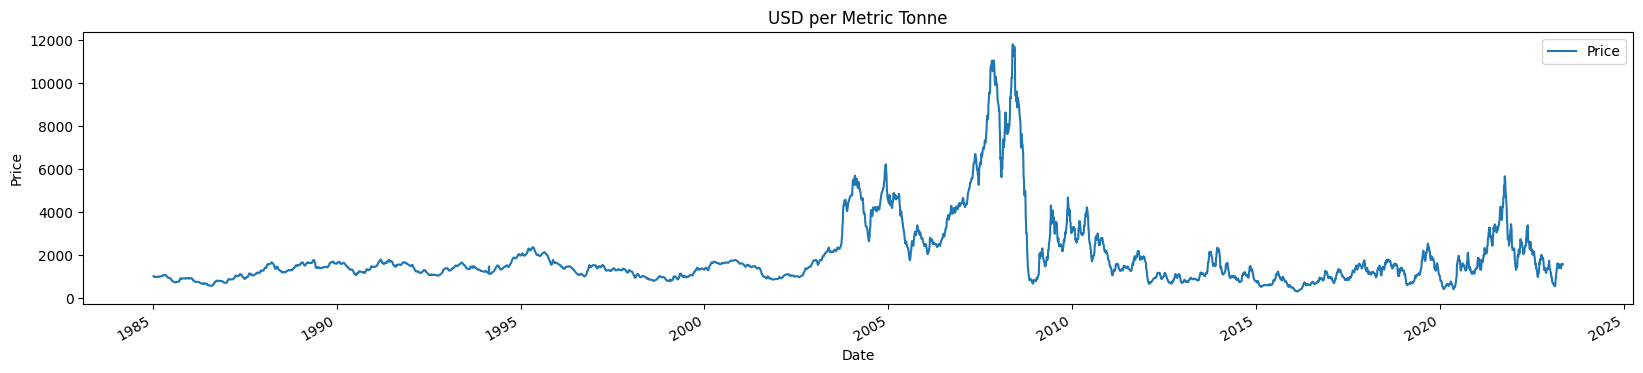

In [ ]:
plotgraph(DBI,'Date','Price')

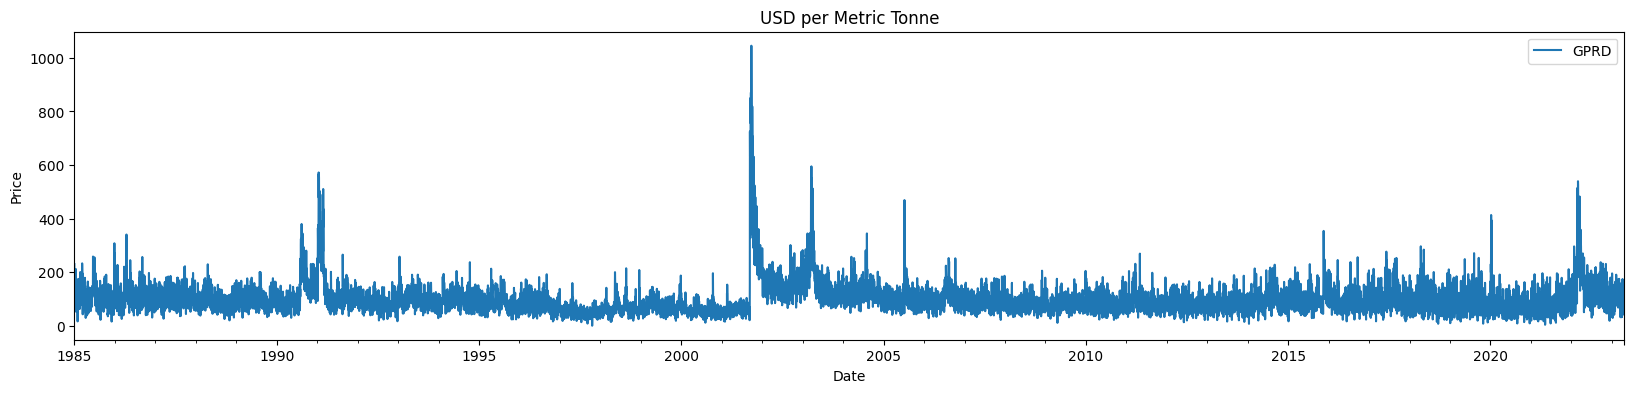

In [ ]:
plotgraph(GPR,'Date','GPRD')

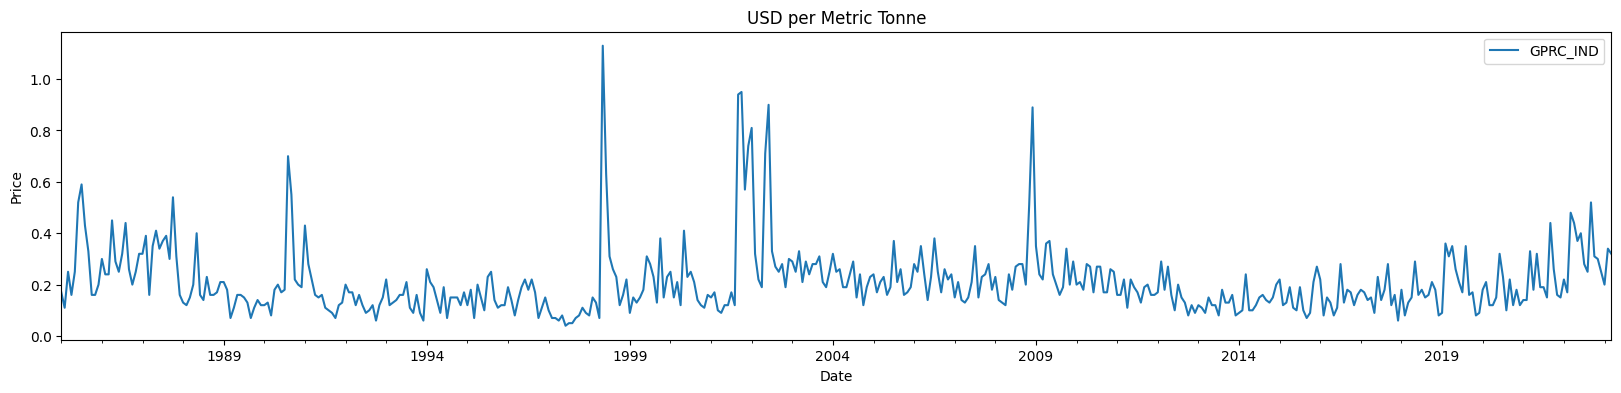

In [ ]:
plotgraph(GPRE,'Date','GPRC_IND')

In [ ]:
# Plotly line plot
fig = go.Figure(data=[go.Scatter(x=DBI['Date'], y=DBI['Price'])])
fig.show()


#####Others

In [ ]:
DBI.head(3)

,Date,Price,Open,High,Low,Vol.,Change %
0,1985-01-07,998.5,998.50,998.50,998.50,NaN,-0.15%
1,1985-01-08,996.5,996.50,996.50,996.50,NaN,-0.20%
2,1985-01-09,994.5,994.50,994.50,994.50,NaN,-0.20%


In [ ]:
DBI = DBI[['Date','Price']]


In [ ]:
DBI.set_index('Date', inplace=True)

In [ ]:

# Resample the data to monthly frequency and calculate the average
DBIM = DBI.resample('M').mean()

# Generate the desired dates for each month
start_date = DBIM.index[0].replace(day=1)
end_date = DBIM.index[-1]
monthly_dates = pd.date_range(start=start_date, end=end_date, freq='MS').strftime('%Y-%m-%d')

# Update the index with the monthly dates
DBIM.index = monthly_dates


In [ ]:
DBIM.index = pd.to_datetime(DBIM.index)

In [ ]:
DBIM.head(3)

,Price
1985-01-01,979.210526
1985-02-01,974.075000
1985-03-01,994.414286


In [ ]:
GPR.head(3)#No USE

,Date,GPRD,event
0,1985-01-01,230.04,NaN
1,1985-01-02,115.68,NaN
2,1985-01-03,97.43,NaN


In [ ]:
GPRE.set_index('Date', inplace=True)
GPRE.head(3)

,GPR,GPRC_ARG,GPRC_AUS,GPRC_BEL,GPRC_BRA,GPRC_CAN,GPRC_CHE,GPRC_CHL,GPRC_CHN,GPRC_COL,...,GPRC_SAU,GPRC_SWE,GPRC_THA,GPRC_TUN,GPRC_TUR,GPRC_TWN,GPRC_UKR,GPRC_USA,GPRC_VEN,GPRC_ZAF
Date,,,,,,,,,,,,,,,,,,,,,
1985-01-01,102.17,0.09,0.06,0.16,0.05,0.41,0.11,0.03,0.28,0.03,...,0.05,0.08,0.25,0.01,0.05,0.03,0.01,2.57,0.01,0.16
1985-02-01,117.10,0.03,0.35,0.18,0.02,0.45,0.06,0.06,0.18,0.06,...,0.12,0.10,0.16,0.03,0.02,0.01,0.01,2.86,0.05,0.08
1985-03-01,124.78,0.08,0.12,0.17,0.02,0.59,0.20,0.09,0.11,0.06,...,0.06,0.02,0.15,0.04,0.24,0.00,0.03,2.95,0.04,0.15


#####Merge Files

In [ ]:
DATA = pd.merge(DBIM, GPRE, left_index=True, right_index=True)
DATA = DATA.rename_axis('Date')


In [ ]:
multiplied_df = DATA.iloc[:, 2:].multiply(DATA['GPR'], axis=0)
multiplied_df


,GPRC_ARG,GPRC_AUS,GPRC_BEL,GPRC_BRA,GPRC_CAN,GPRC_CHE,GPRC_CHL,GPRC_CHN,GPRC_COL,GPRC_DEU,...,GPRC_SAU,GPRC_SWE,GPRC_THA,GPRC_TUN,GPRC_TUR,GPRC_TWN,GPRC_UKR,GPRC_USA,GPRC_VEN,GPRC_ZAF
Date,,,,,,,,,,,,,,,,,,,,,
1985-01-01,9.1953,6.1302,16.3472,5.1085,41.8897,11.2387,3.0651,28.6076,3.0651,27.5859,...,5.1085,8.1736,25.5425,1.0217,5.1085,3.0651,1.0217,262.5769,1.0217,16.3472
1985-02-01,3.5130,40.9850,21.0780,2.3420,52.6950,7.0260,7.0260,21.0780,7.0260,58.5500,...,14.0520,11.7100,18.7360,3.5130,2.3420,1.1710,1.1710,334.9060,5.8550,9.3680
1985-03-01,9.9824,14.9736,21.2126,2.4956,73.6202,24.9560,11.2302,13.7258,7.4868,41.1774,...,7.4868,2.4956,18.7170,4.9912,29.9472,0.0000,3.7434,368.1010,4.9912,18.7170
1985-04-01,2.6379,6.1551,7.0344,2.6379,29.8962,1.7586,4.3965,17.5860,12.3102,29.8962,...,8.7930,2.6379,4.3965,0.0000,10.5516,1.7586,2.6379,175.8600,10.5516,12.3102
1985-05-01,7.2282,4.1304,10.3260,7.2282,44.4018,6.1956,5.1630,13.4238,9.2934,54.7278,...,9.2934,8.2608,6.1956,2.0652,2.0652,1.0326,1.0326,246.7914,11.3586,16.5216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-01,3.5622,14.2488,33.2472,15.4362,33.2472,5.9370,1.1874,136.5510,1.1874,85.4928,...,20.1858,16.6236,4.7496,3.5622,58.1826,47.4960,294.4752,326.5350,3.5622,9.4992
2022-12-01,3.4158,22.7720,21.6334,6.8316,25.0492,6.8316,1.1386,101.3354,4.5544,60.3458,...,19.3562,12.5246,3.4158,1.1386,29.6036,34.1580,257.3236,296.0360,6.8316,4.5544
2023-01-01,3.1689,13.7319,22.1823,12.6756,30.6327,17.9571,2.1126,73.9410,1.0563,95.0670,...,5.2815,17.9571,3.1689,1.0563,23.2386,17.9571,210.2037,255.6246,3.1689,4.2252


In [ ]:
# Creating a new DataFrame by combining the selected columns
DATA = pd.concat([DATA[['Price','GPR']], multiplied_df], axis=1)


In [ ]:
DATA

,Price,GPR,GPRC_ARG,GPRC_AUS,GPRC_BEL,GPRC_BRA,GPRC_CAN,GPRC_CHE,GPRC_CHL,GPRC_CHN,...,GPRC_SAU,GPRC_SWE,GPRC_THA,GPRC_TUN,GPRC_TUR,GPRC_TWN,GPRC_UKR,GPRC_USA,GPRC_VEN,GPRC_ZAF
Date,,,,,,,,,,,,,,,,,,,,,
1985-01-01,979.210526,102.17,9.1953,6.1302,16.3472,5.1085,41.8897,11.2387,3.0651,28.6076,...,5.1085,8.1736,25.5425,1.0217,5.1085,3.0651,1.0217,262.5769,1.0217,16.3472
1985-02-01,974.075000,117.10,3.5130,40.9850,21.0780,2.3420,52.6950,7.0260,7.0260,21.0780,...,14.0520,11.7100,18.7360,3.5130,2.3420,1.1710,1.1710,334.9060,5.8550,9.3680
1985-03-01,994.414286,124.78,9.9824,14.9736,21.2126,2.4956,73.6202,24.9560,11.2302,13.7258,...,7.4868,2.4956,18.7170,4.9912,29.9472,0.0000,3.7434,368.1010,4.9912,18.7170
1985-04-01,1045.275000,87.93,2.6379,6.1551,7.0344,2.6379,29.8962,1.7586,4.3965,17.5860,...,8.7930,2.6379,4.3965,0.0000,10.5516,1.7586,2.6379,175.8600,10.5516,12.3102
1985-05-01,1004.309524,103.26,7.2282,4.1304,10.3260,7.2282,44.4018,6.1956,5.1630,13.4238,...,9.2934,8.2608,6.1956,2.0652,2.0652,1.0326,1.0326,246.7914,11.3586,16.5216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-01,1298.954545,118.74,3.5622,14.2488,33.2472,15.4362,33.2472,5.9370,1.1874,136.5510,...,20.1858,16.6236,4.7496,3.5622,58.1826,47.4960,294.4752,326.5350,3.5622,9.4992
2022-12-01,1453.411765,113.86,3.4158,22.7720,21.6334,6.8316,25.0492,6.8316,1.1386,101.3354,...,19.3562,12.5246,3.4158,1.1386,29.6036,34.1580,257.3236,296.0360,6.8316,4.5544
2023-01-01,908.809524,105.63,3.1689,13.7319,22.1823,12.6756,30.6327,17.9571,2.1126,73.9410,...,5.2815,17.9571,3.1689,1.0563,23.2386,17.9571,210.2037,255.6246,3.1689,4.2252


#####Preliminary analysis

In [ ]:
print(DATA.describe())

              Price         GPR    GPRC_ARG    GPRC_AUS    GPRC_BEL  \
count    459.000000  459.000000  459.000000  459.000000  459.000000   
mean    1880.561310  100.647211    3.643837   10.754778   16.999907   
std     1605.455852   47.915949    5.755761   18.791836   29.849974   
min      306.904762   39.050000    0.000000    0.000000    0.877300   
25%     1031.597403   79.395000    1.143550    3.392750    5.383000   
50%     1401.800000   90.610000    2.092200    5.840100    9.796800   
75%     1933.772727  109.080000    3.765650   11.241400   17.826400   
max    10843.650000  512.530000   64.824500  205.012000  335.182600   

         GPRC_BRA    GPRC_CAN    GPRC_CHE    GPRC_CHL    GPRC_CHN  ...  \
count  459.000000  459.000000  459.000000  459.000000  459.000000  ...   
mean     5.494832   29.458721    7.941876    2.302707   46.736675  ...   
std      7.721717   63.759778   19.642482    5.683549   58.798234  ...   
min      0.000000    2.733500    0.000000    0.000000    5.40600

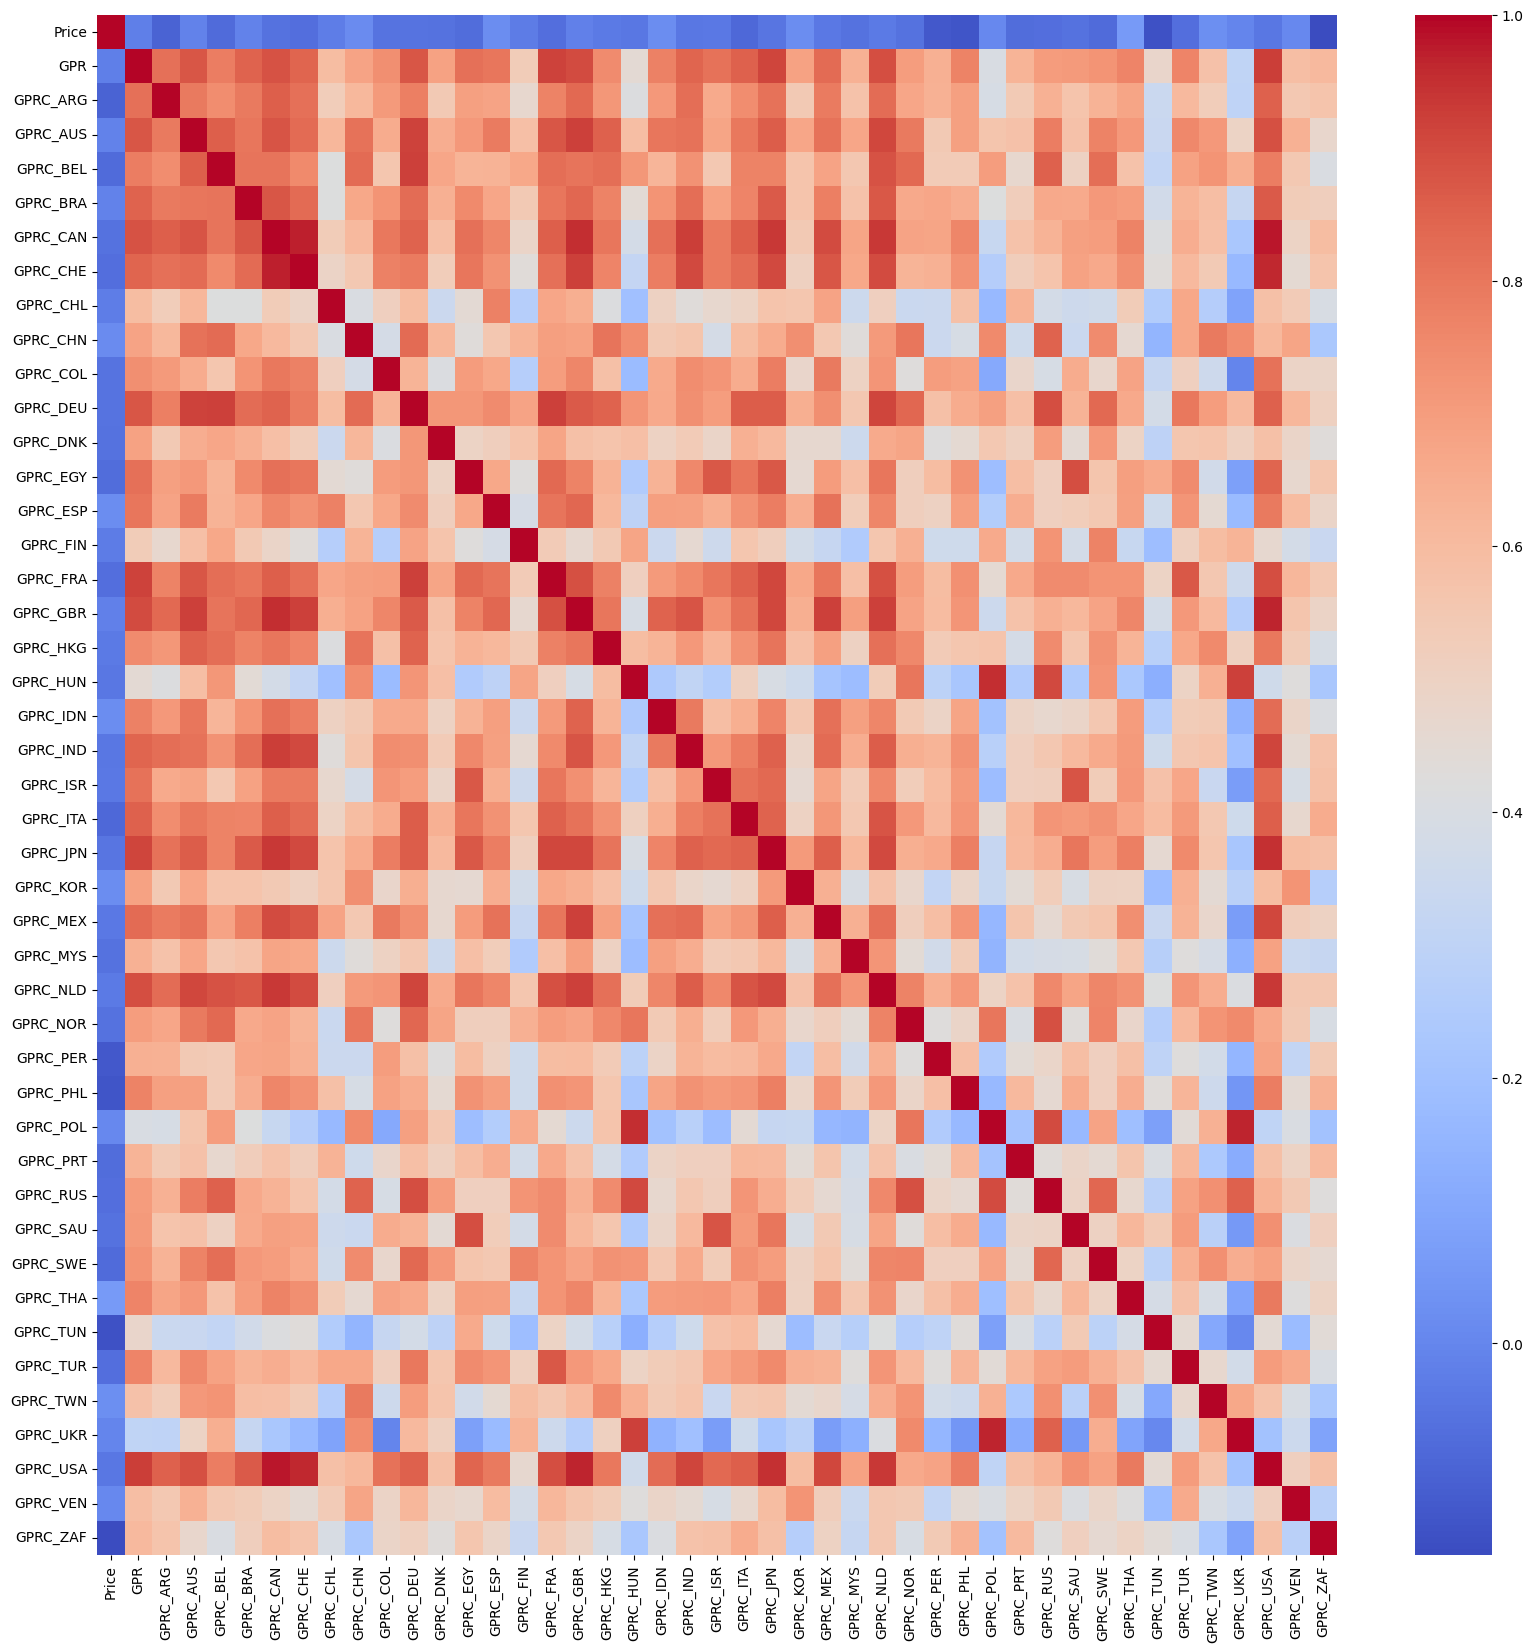

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(DATA.corr(),cmap='coolwarm');

<ipython-input-118-f54c41804d8a>:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='Price', ylabel='Density'>

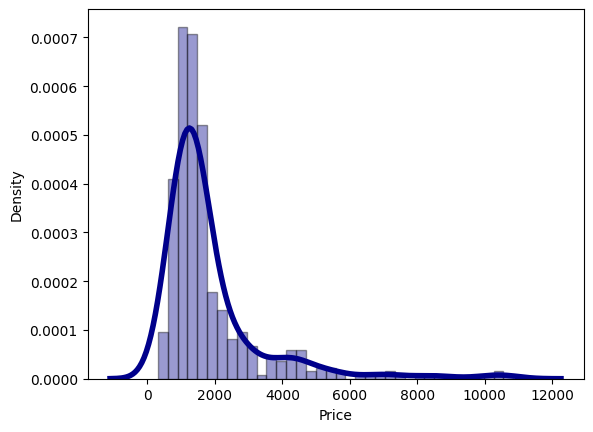

In [ ]:
sns.distplot(DATA['Price'], hist=True, kde=True,
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

<ipython-input-119-f9d9a019782f>:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='GPR', ylabel='Density'>

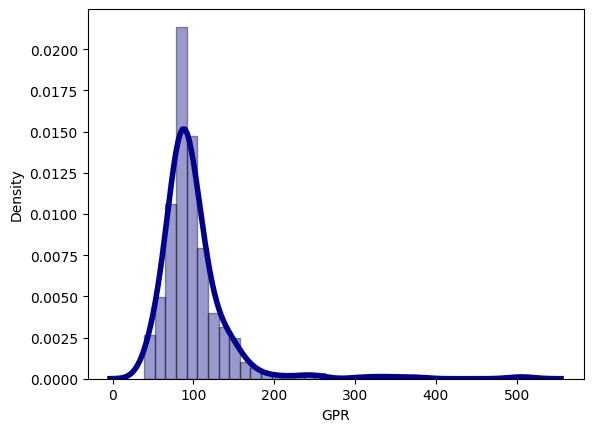

In [ ]:
sns.distplot(DATA['GPR'], hist=True, kde=True,
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

In [ ]:
DATA.head(2)

,Price,GPR,GPRC_ARG,GPRC_AUS,GPRC_BEL,GPRC_BRA,GPRC_CAN,GPRC_CHE,GPRC_CHL,GPRC_CHN,...,GPRC_SAU,GPRC_SWE,GPRC_THA,GPRC_TUN,GPRC_TUR,GPRC_TWN,GPRC_UKR,GPRC_USA,GPRC_VEN,GPRC_ZAF
Date,,,,,,,,,,,,,,,,,,,,,
1985-01-01,979.210526,102.17,9.1953,6.1302,16.3472,5.1085,41.8897,11.2387,3.0651,28.6076,...,5.1085,8.1736,25.5425,1.0217,5.1085,3.0651,1.0217,262.5769,1.0217,16.3472
1985-02-01,974.075000,117.10,3.5130,40.9850,21.0780,2.3420,52.6950,7.0260,7.0260,21.0780,...,14.0520,11.7100,18.7360,3.5130,2.3420,1.1710,1.1710,334.9060,5.8550,9.3680


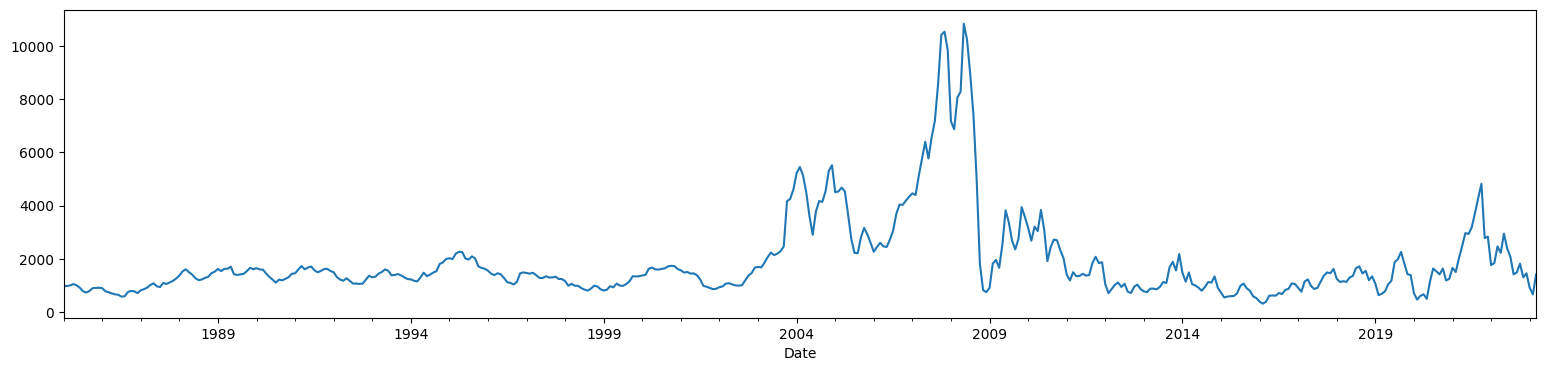

In [ ]:
DATA['Price'].plot(figsize=(19, 4))
plt.show()

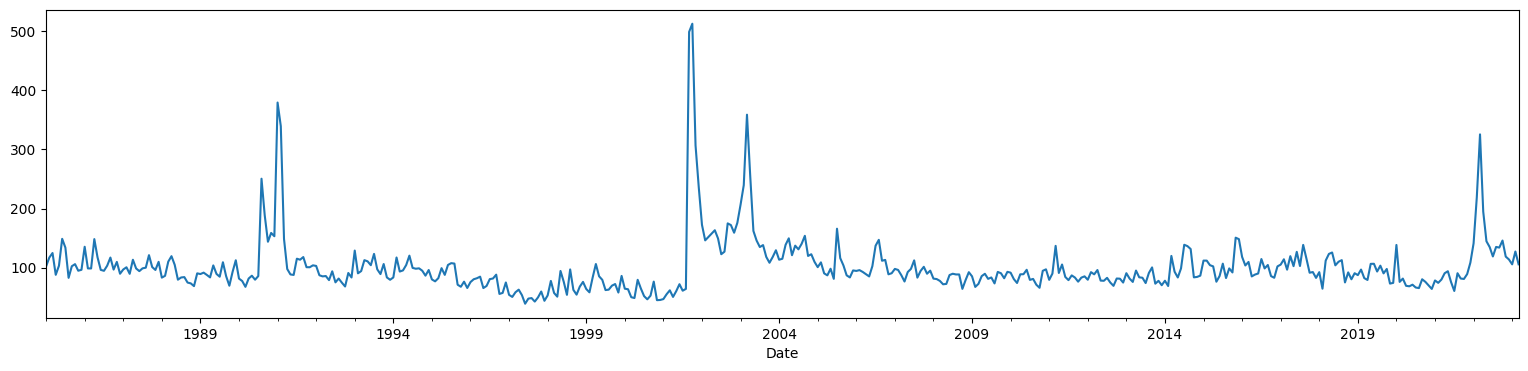

In [ ]:
DATA['GPR'].plot(figsize=(19, 4))
plt.show()

In [ ]:
DATA['GPRC_USA']

Date
1985-01-01    262.5769
1985-02-01    334.9060
1985-03-01    368.1010
1985-04-01    175.8600
1985-05-01    246.7914
                ...   
2022-11-01    326.5350
2022-12-01    296.0360
2023-01-01    255.6246
2023-02-01    401.1210
2023-03-01    286.4199
Name: GPRC_USA, Length: 459, dtype: float64

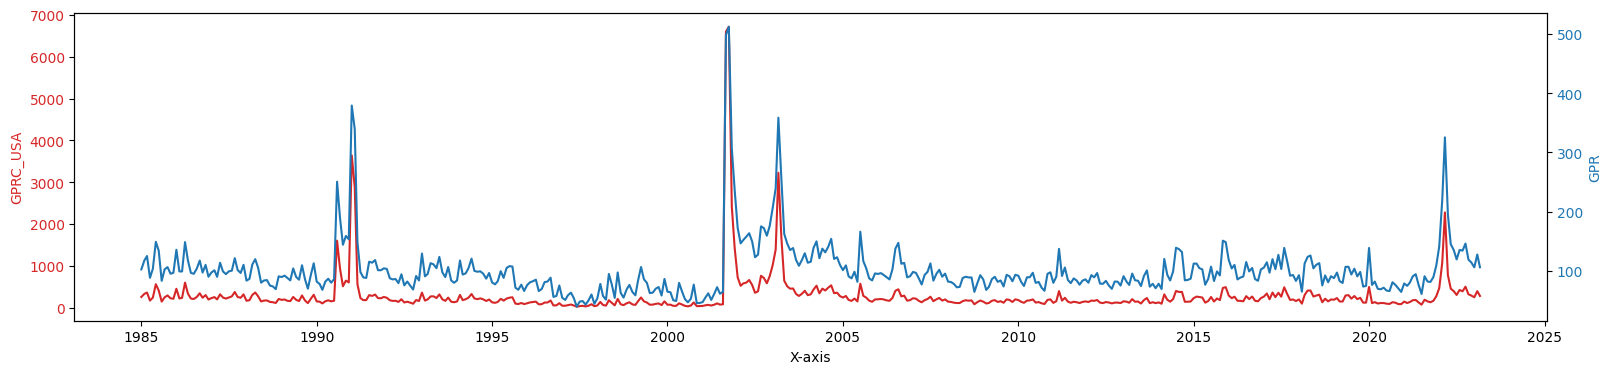

In [ ]:
# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(19, 4))

color1 = 'tab:red'
ax1.plot(DATA['GPRC_USA'], color=color1)
ax1.set_ylabel('GPRC_USA', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

# Create a second y-axis (right)
ax2 = ax1.twinx()

# Plot the second dataset on the second y-axis (right)
color2 = 'tab:blue'
ax2.plot(DATA['GPR'], color=color2)
ax2.set_ylabel('GPR', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# Set x-axis label
ax1.set_xlabel('X-axis')

# Show the plot
plt.show()

#####Second Round Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

#####Tests & Country Selection

In [ ]:
#testing for causality with granger's causality test
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(DATA, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(DATA[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

Pvalues = grangers_causation_matrix(DATA, variables = DATA.columns)
#If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row).

In [ ]:
Countries = Pvalues[Pvalues['Price_x'] < 0.05].index
Countries

Index(['GPRC_BEL_y', 'GPRC_CHN_y', 'GPRC_HKG_y', 'GPRC_HUN_y', 'GPRC_NOR_y',
       'GPRC_POL_y', 'GPRC_RUS_y', 'GPRC_TUN_y', 'GPRC_TWN_y', 'GPRC_UKR_y',
       'GPRC_VEN_y'],
      dtype='object')

In [ ]:
Pvalues

,Price_x,GPR_x,GPRC_ARG_x,GPRC_AUS_x,GPRC_BEL_x,GPRC_BRA_x,GPRC_CAN_x,GPRC_CHE_x,GPRC_CHL_x,GPRC_CHN_x,...,GPRC_SAU_x,GPRC_SWE_x,GPRC_THA_x,GPRC_TUN_x,GPRC_TUR_x,GPRC_TWN_x,GPRC_UKR_x,GPRC_USA_x,GPRC_VEN_x,GPRC_ZAF_x
Price_y,1.0000,0.4235,0.5702,0.4951,0.7136,0.5467,0.7801,0.5662,0.0298,0.1560,...,0.7413,0.6824,0.5338,0.8633,0.3106,0.0412,0.0388,0.6727,0.0340,0.8334
GPR_y,0.5964,1.0000,0.2313,0.4421,0.0051,0.0003,0.0003,0.0450,0.1338,0.2018,...,0.0053,0.2427,0.0421,0.1421,0.0102,0.7872,0.7475,0.0015,0.0258,0.5770
GPRC_ARG_y,0.0923,0.0006,1.0000,0.0099,0.0002,0.0000,0.0000,0.0044,0.0307,0.3527,...,0.0890,0.0021,0.2068,0.5530,0.0319,0.6716,0.4870,0.0001,0.2426,0.1628
GPRC_AUS_y,0.0950,0.0002,0.0000,1.0000,0.0000,0.0000,0.0000,0.0066,0.2044,0.0432,...,0.5221,0.0011,0.0044,0.0263,0.1483,0.0408,0.3732,0.0000,0.0064,0.2024
GPRC_BEL_y,0.0193,0.0439,0.0007,0.0603,1.0000,0.0015,0.0060,0.0113,0.3139,0.4827,...,0.0450,0.0102,0.0285,0.0320,0.0115,0.1492,0.5986,0.0042,0.5597,0.0507
GPRC_BRA_y,0.2969,0.0369,0.6363,0.1164,0.0170,1.0000,0.1133,0.1716,0.0165,0.4532,...,0.2643,0.1297,0.5832,0.5695,0.2305,0.2241,0.5225,0.0930,0.1265,0.7725
GPRC_CAN_y,0.4243,0.1087,0.2342,0.1259,0.0779,0.0000,1.0000,0.0066,0.2283,0.3729,...,0.0030,0.7134,0.8160,0.0836,0.0038,0.5850,0.4857,0.0214,0.0046,0.3788
GPRC_CHE_y,0.4324,0.0390,0.0004,0.3834,0.0009,0.0000,0.0000,1.0000,0.2127,0.7992,...,0.0003,0.1084,0.1180,0.1537,0.0106,0.7746,0.2619,0.0000,0.0011,0.6723
GPRC_CHL_y,0.5742,0.0000,0.0006,0.0001,0.0001,0.0000,0.0003,0.0002,1.0000,0.0010,...,0.0627,0.0008,0.0046,0.7911,0.2457,0.0112,0.5284,0.0003,0.0000,0.0002
GPRC_CHN_y,0.0001,0.0118,0.0141,0.0681,0.0000,0.0000,0.0003,0.0917,0.0039,1.0000,...,0.3780,0.0002,0.0704,0.1690,0.3902,0.0470,0.6073,0.0078,0.2481,0.0547


In [ ]:
DATA = DATA[['Price','GPRC_BRA','GPRC_USA','GPRC_CHN','GPRC_HKG','GPRC_IND','GPRC_NLD','GPRC_TWN','GPRC_RUS','GPRC_UKR','GPRC_ZAF','GPRC_AUS']]

In [ ]:
DATA

,Price,GPRC_BRA,GPRC_USA,GPRC_CHN,GPRC_HKG,GPRC_IND,GPRC_NLD,GPRC_TWN,GPRC_RUS,GPRC_UKR,GPRC_ZAF,GPRC_AUS
Date,,,,,,,,,,,,
1985-01-01,979.210526,5.1085,262.5769,28.6076,1.0217,17.3689,11.2387,3.0651,144.0597,1.0217,16.3472,6.1302
1985-02-01,974.075000,2.3420,334.9060,21.0780,5.8550,12.8810,10.5390,1.1710,160.4270,1.1710,9.3680,40.9850
1985-03-01,994.414286,2.4956,368.1010,13.7258,2.4956,31.1950,8.7346,0.0000,188.4178,3.7434,18.7170,14.9736
1985-04-01,1045.275000,2.6379,175.8600,17.5860,1.7586,14.0688,4.3965,1.7586,80.0163,2.6379,12.3102,6.1551
1985-05-01,1004.309524,7.2282,246.7914,13.4238,1.0326,25.8150,4.1304,1.0326,119.7816,1.0326,16.5216,4.1304
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-01,1298.954545,15.4362,326.5350,136.5510,22.5606,35.6220,13.0614,47.4960,295.6626,294.4752,9.4992,14.2488
2022-12-01,1453.411765,6.8316,296.0360,101.3354,7.9702,28.4650,10.2474,34.1580,265.2938,257.3236,4.5544,22.7720
2023-01-01,908.809524,12.6756,255.6246,73.9410,3.1689,21.1260,22.1823,17.9571,214.4289,210.2037,4.2252,13.7319


In [ ]:
#cointegration test to find statistical relation amongst variables.
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(DATA, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(DATA,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(DATA.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(DATA)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Price  ::  524.94    > 311.1288  =>   True
GPRC_BRA ::  428.78    > 263.2603  =>   True
GPRC_USA ::  342.59    > 219.4051  =>   True
GPRC_CHN ::  267.46    > 179.5199  =>   True
GPRC_HKG ::  208.93    > 143.6691  =>   True
GPRC_IND ::  153.84    > 111.7797  =>   True
GPRC_NLD ::  108.43    > 83.9383   =>   True
GPRC_TWN ::  69.62     > 60.0627   =>   True
GPRC_RUS ::  37.08     > 40.1749   =>   False
GPRC_UKR ::  19.87     > 24.2761   =>   False
GPRC_ZAF ::  7.05      > 12.3212   =>   False
GPRC_AUS ::  0.83      > 4.1296    =>   False


If there is cointegration:
1.    Implies that the series in question are related and therefore can be combined in a linear fashion.
2.  That is, even if there are shocks in the short run, which may affect movement in the individual series, they would converge with time (in the long run).
3.    Estimate both long-run and short-run models.
4. The estimation will require the use of vector autoregressive (VAR) model and vector error correction model (VECM) analysis.

If there is no cointegration:
1.    Estimate only the short-run model, which is VAR and not VECM.
source : http://cruncheconometrix.blogspot.com/2018/03/time-series-analysis-lecture-4-part-1.html

In [ ]:
nobs = 20
DATA_train, DATA_test = DATA[0:-nobs], DATA[-nobs:]

# Check size
print(DATA_train.shape)  # (439, 12)
print(DATA_test.shape)  # (20, 12)

(439, 12)
(20, 12)


In [ ]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [ ]:
# ADF Test on each column
for name, column in DATA_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.4924
 No. Lags Chosen       = 9
 Critical value 1%     = -3.446
 Critical value 5%     = -2.868
 Critical value 10%    = -2.57
 => P-Value = 0.0082. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "GPRC_BRA" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.5124
 No. Lags Chosen       = 0
 Critical value 1%     = -3.445
 Critical value 5%     = -2.868
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "GPRC_USA" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level

<ipython-input-135-bfc95715b77e>:2: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



    Augmented Dickey-Fuller Test on "GPRC_HKG" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.7752
 No. Lags Chosen       = 2
 Critical value 1%     = -3.445
 Critical value 5%     = -2.868
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "GPRC_IND" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.5912
 No. Lags Chosen       = 6
 Critical value 1%     = -3.446
 Critical value 5%     = -2.868
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "GPRC_NLD" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level 

In [ ]:
#series needs to be stationary hence differencing it.
#1st difference
DATA_train = DATA_train.diff().dropna()


In [ ]:
# ADF Test on each column
for name, column in DATA_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.9044
 No. Lags Chosen       = 16
 Critical value 1%     = -3.446
 Critical value 5%     = -2.868
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "GPRC_BRA" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.3006
 No. Lags Chosen       = 14
 Critical value 1%     = -3.446
 Critical value 5%     = -2.868
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "GPRC_USA" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level  

<ipython-input-137-bfc95715b77e>:2: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



 -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.5069
 No. Lags Chosen       = 6
 Critical value 1%     = -3.446
 Critical value 5%     = -2.868
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "GPRC_NLD" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.792
 No. Lags Chosen       = 15
 Critical value 1%     = -3.446
 Critical value 5%     = -2.868
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "GPRC_TWN" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.9835
 No. La

Now after 1st order of differencing as per the ADF test where p value < 0.05 it can be said the series is stationary

#####VAR

In [ ]:
model = VAR(DATA_train)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  66.78740072164
BIC :  68.24385284620502
FPE :  1.0127240152265265e+29
HQIC:  67.36213307170846 

Lag Order = 2
AIC :  65.9645956348427
BIC :  68.77031277476176
FPE :  4.453650887731792e+28
HQIC:  67.07186650435506 

Lag Order = 3
AIC :  65.492746617993
BIC :  69.65241015317318
FPE :  2.787955321347749e+28
HQIC:  67.13450336590003 

Lag Order = 4
AIC :  65.39330170795854
BIC :  70.9116201089978
FPE :  2.5409080500135673e+28
HQIC:  67.57150313381611 

Lag Order = 5
AIC :  65.30437145648666
BIC :  72.18608050244006
FPE :  2.350496193345874e+28
HQIC:  68.02098789250982 



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



Lag Order = 6
AIC :  65.32400184957103
BIC :  73.57386484795492
FPE :  2.4373129430375437e+28
HQIC:  68.58101525362677 

Lag Order = 7
AIC :  65.47826529004877
BIC :  75.101073299111
FPE :  2.911649959837085e+28
HQIC:  69.27766933959934 

Lag Order = 8
AIC :  65.48232370244587
BIC :  76.48289575573047
FPE :  3.0182714892352657e+28
HQIC:  69.82612388945435 

Lag Order = 9
AIC :  65.68897610786428
BIC :  78.07215944109934
FPE :  3.8695653131322964e+28
HQIC:  70.57918983467412 



In [ ]:
x = model.select_order(maxlags=12)
x.summary()


,AIC,BIC,FPE,HQIC
0,68.63,68.74,6.377e+29,68.67
1,66.61,68.10*,8.520e+28,67.20
2,65.79,68.64,3.724e+28,66.91*
3,65.31,69.53,2.316e+28,66.98
4,65.21,70.81,2.123e+28,67.42
5,65.16*,72.13,2.035e+28*,67.91
6,65.19,73.53,2.135e+28,68.48
7,65.31,75.02,2.475e+28,69.15
8,65.38,76.46,2.724e+28,69.75
9,65.56,78.01,3.418e+28,70.48


In [ ]:
model_fitted = model.fit(2)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 18, May, 2023
Time:                     06:42:32
--------------------------------------------------------------------
No. of Equations:         12.0000    BIC:                    68.7703
Nobs:                     436.000    HQIC:                   67.0719
Log likelihood:          -21504.2    FPE:                4.45365e+28
AIC:                      65.9646    Det(Omega_mle):     2.28109e+28
--------------------------------------------------------------------
Results for equation Price
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               3.138135        18.793752            0.167           0.867
L1.Price            0.436749         0.049079            8.899           0.000
L1.GPRC_BRA       -17.314736         5.565869           -3.111      

In [ ]:
#to check if any serial pattern is still left in the residuals durbin watson statistical test can be performed.
#The value of this statistic can vary between 0 and 4. The closer it is to the value 2, 
#then there is no significant serial correlation.
#The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(DATA_train.columns, out):
    print(col, ':', round(val, 2))

Price : 2.02
GPRC_BRA : 2.11
GPRC_USA : 2.07
GPRC_CHN : 2.01
GPRC_HKG : 2.12
GPRC_IND : 2.04
GPRC_NLD : 2.11
GPRC_TWN : 2.05
GPRC_RUS : 2.11
GPRC_UKR : 2.14
GPRC_ZAF : 2.09
GPRC_AUS : 2.08


As the values are closer to 2 no significant correlation.

#####Forecast

In [ ]:
#forecasting
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = DATA_train.values[-lag_order:]
forecast_input

2


array([[-3.32631579e+01, -7.37600000e-01, -6.16188000e+01,
        -3.67220000e+00,  3.05960000e+00, -1.57262000e+01,
         9.76600000e-01,  5.46000000e-02, -1.56740000e+01,
        -9.10840000e+00,  1.82000000e-02, -2.37900000e+00],
       [ 2.55954545e+02, -2.41720000e+00, -5.04618000e+01,
        -2.47168000e+01, -4.52120000e+00, -2.84620000e+00,
        -2.71000000e+00, -4.06500000e+00, -3.27310000e+01,
        -1.28282000e+01, -1.35500000e+00, -9.36240000e+00]])

In [ ]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=DATA.index[-nobs:], columns=DATA.columns + '_2d')
df_forecast

,Price_2d,GPRC_BRA_2d,GPRC_USA_2d,GPRC_CHN_2d,GPRC_HKG_2d,GPRC_IND_2d,GPRC_NLD_2d,GPRC_TWN_2d,GPRC_RUS_2d,GPRC_UKR_2d,GPRC_ZAF_2d,GPRC_AUS_2d
Date,,,,,,,,,,,,
2021-08-01,186.279919,2.689458,63.779495,17.843212,2.093021,11.715699,4.079894,3.134933,20.261547,12.542363,0.814718,5.974217
2021-09-01,-15.119814,-1.387319,-40.954874,-8.677572,-1.009698,-4.947711,-1.519041,-0.506653,-5.777639,-2.128454,0.042236,-1.926657
2021-10-01,6.634189,-0.252910,-11.199745,0.860999,-0.434727,-3.439332,-1.406980,-0.878432,-1.601764,-2.463487,-0.605893,-0.517468
2021-11-01,9.602075,0.502993,2.071791,2.701822,0.797987,2.093541,0.836033,0.603574,-2.241797,0.899876,0.027566,-0.084398
2021-12-01,3.581981,-0.196490,12.723457,-1.863474,-0.237430,1.260336,0.450768,0.038492,1.416796,0.204690,0.189921,0.745808
2022-01-01,5.151382,0.085656,1.728811,0.756940,0.076238,-1.004352,-0.162409,-0.055895,2.580068,0.304047,0.020804,-0.146205
2022-02-01,4.486912,-0.032184,-10.572559,0.105973,0.005790,-0.393036,-0.347592,0.031649,-2.840332,-0.190030,-0.202135,-0.440651
2022-03-01,5.453157,-0.051233,1.090259,-0.274406,-0.119620,0.434095,0.162927,-0.021623,-0.728735,-0.139020,-0.007604,0.180748
2022-04-01,4.789754,0.052728,3.563149,0.289001,0.155606,-0.016025,0.119980,0.047960,1.012795,0.203690,0.064318,0.034332


In [ ]:
#inverting the values from differencing
def invert_transformation(DATA_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = DATA_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_2d'] = (DATA_train[col].iloc[-1]-DATA_train[col].iloc[-2]) + DATA_train[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = DATA_train[col].iloc[-1] + df_fc[str(col)+'_2d'].cumsum()
    return df_fc

In [ ]:
df_results = invert_transformation(DATA_train, df_forecast)        
df_results

,Price_2d,GPRC_BRA_2d,GPRC_USA_2d,GPRC_CHN_2d,GPRC_HKG_2d,GPRC_IND_2d,GPRC_NLD_2d,GPRC_TWN_2d,GPRC_RUS_2d,GPRC_UKR_2d,...,GPRC_USA_forecast,GPRC_CHN_forecast,GPRC_HKG_forecast,GPRC_IND_forecast,GPRC_NLD_forecast,GPRC_TWN_forecast,GPRC_RUS_forecast,GPRC_UKR_forecast,GPRC_ZAF_forecast,GPRC_AUS_forecast
Date,,,,,,,,,,,,,,,,,,,,,
2021-08-01,186.279919,2.689458,63.779495,17.843212,2.093021,11.715699,4.079894,3.134933,20.261547,12.542363,...,13.317695,-6.873588,-2.428179,8.869499,1.369894,-0.930067,-12.469453,-0.285837,-0.540282,-3.388183
2021-09-01,-15.119814,-1.387319,-40.954874,-8.677572,-1.009698,-4.947711,-1.519041,-0.506653,-5.777639,-2.128454,...,-27.637180,-15.551160,-3.437877,3.921789,-0.149147,-1.436720,-18.247093,-2.414291,-0.498046,-5.314840
2021-10-01,6.634189,-0.252910,-11.199745,0.860999,-0.434727,-3.439332,-1.406980,-0.878432,-1.601764,-2.463487,...,-38.836925,-14.690161,-3.872604,0.482457,-1.556126,-2.315153,-19.848857,-4.877779,-1.103939,-5.832309
2021-11-01,9.602075,0.502993,2.071791,2.701822,0.797987,2.093541,0.836033,0.603574,-2.241797,0.899876,...,-36.765133,-11.988339,-3.074616,2.575997,-0.720093,-1.711578,-22.090654,-3.977902,-1.076374,-5.916707
2021-12-01,3.581981,-0.196490,12.723457,-1.863474,-0.237430,1.260336,0.450768,0.038492,1.416796,0.204690,...,-24.041676,-13.851813,-3.312046,3.836333,-0.269325,-1.673086,-20.673857,-3.773213,-0.886453,-5.170899
2022-01-01,5.151382,0.085656,1.728811,0.756940,0.076238,-1.004352,-0.162409,-0.055895,2.580068,0.304047,...,-22.312865,-13.094873,-3.235808,2.831982,-0.431735,-1.728980,-18.093789,-3.469165,-0.865649,-5.317105
2022-02-01,4.486912,-0.032184,-10.572559,0.105973,0.005790,-0.393036,-0.347592,0.031649,-2.840332,-0.190030,...,-32.885425,-12.988900,-3.230018,2.438946,-0.779326,-1.697331,-20.934121,-3.659196,-1.067783,-5.757756
2022-03-01,5.453157,-0.051233,1.090259,-0.274406,-0.119620,0.434095,0.162927,-0.021623,-0.728735,-0.139020,...,-31.795166,-13.263306,-3.349639,2.873041,-0.616400,-1.718954,-21.662856,-3.798215,-1.075387,-5.577008
2022-04-01,4.789754,0.052728,3.563149,0.289001,0.155606,-0.016025,0.119980,0.047960,1.012795,0.203690,...,-28.232017,-12.974306,-3.194033,2.857016,-0.496420,-1.670994,-20.650062,-3.594526,-1.011069,-5.542676


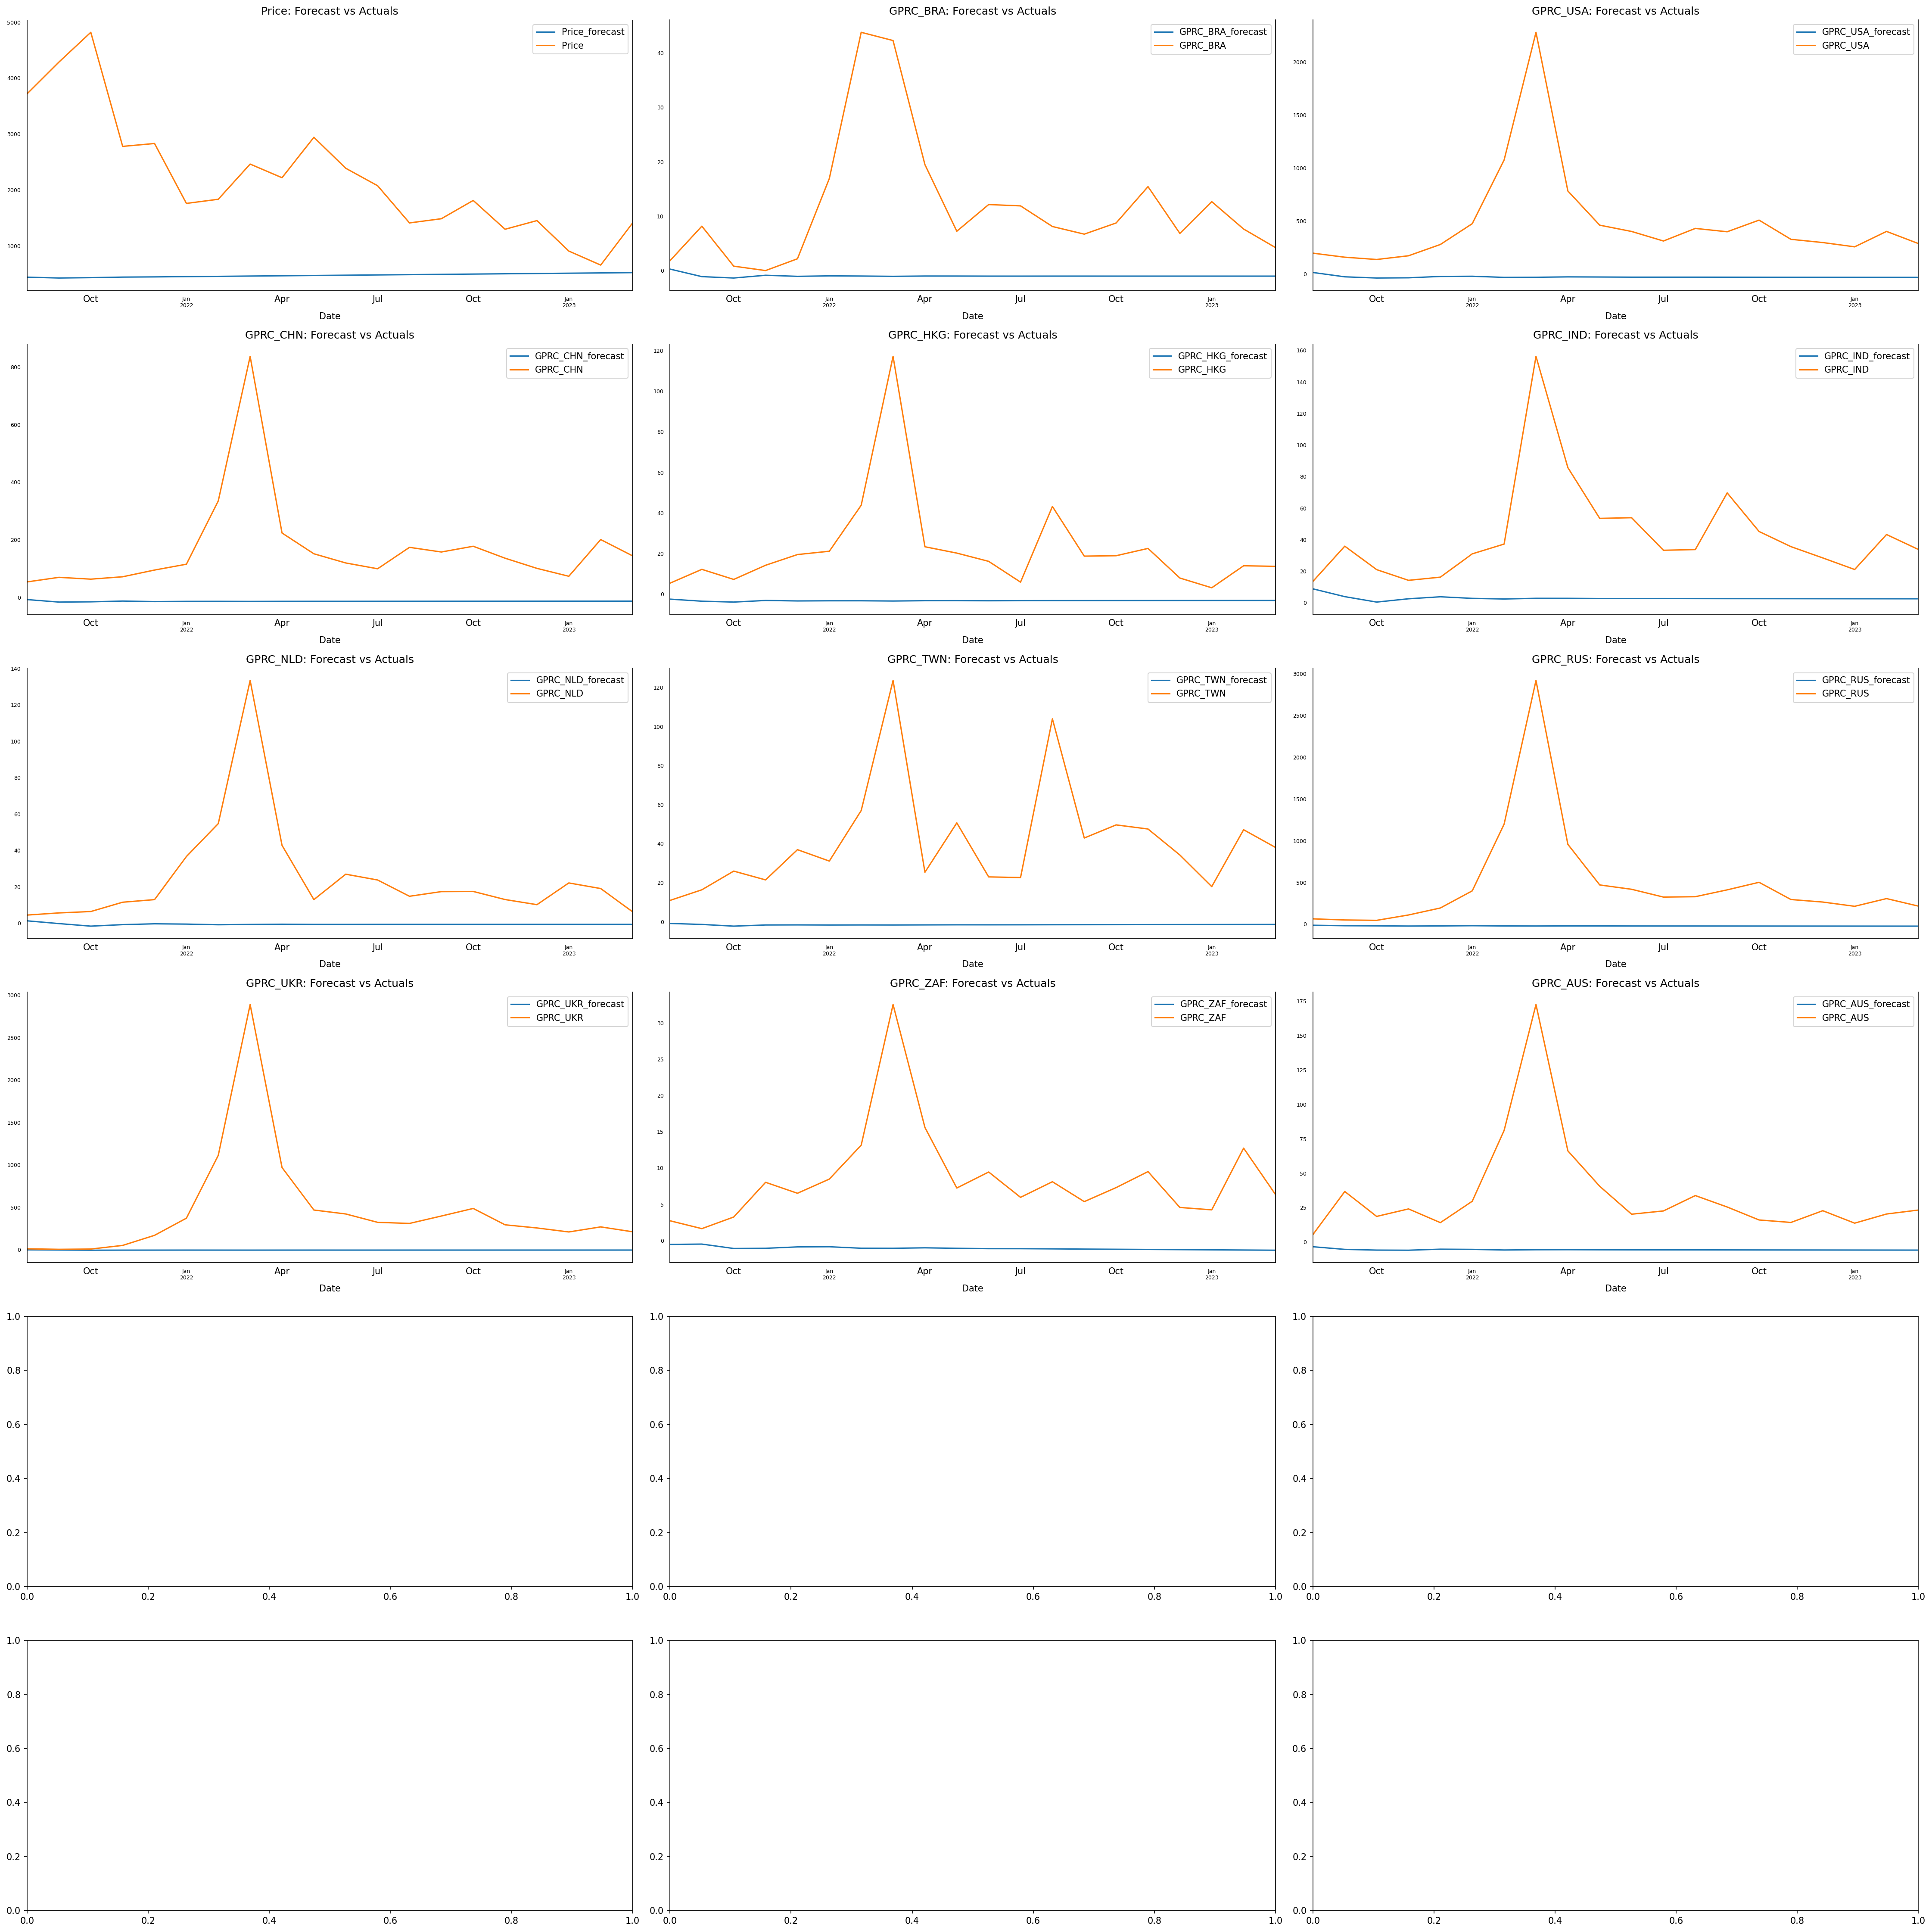

In [ ]:
fig, axes = plt.subplots(nrows=int(len(DATA.columns)/2), ncols=3, dpi=150, figsize=(30,30))
for i, (col,ax) in enumerate(zip(DATA.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    DATA_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();